# Aligning MUSE, MIRI and HI images
This code aligns Halpha MUSE, Medium Infrared JWST/MIRI and HI images. The latter is thus cropped.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import math
from matplotlib.colors import LogNorm

import math
from astropy.wcs import WCS
from scipy.fftpack import fft2, fftshift
from scipy.fft import fft, fftfreq
from scipy.ndimage import map_coordinates
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import make_lupton_rgb
from skimage.feature import peak_local_max
from astropy.visualization import simple_norm
from scipy.spatial import cKDTree

from matplotlib.patches import Circle
from astropy.visualization.wcsaxes import SphericalCircle
from scipy.signal import resample
from scipy.signal import find_peaks
from matplotlib.patches import Wedge
from reproject import reproject_interp

from turbustat.statistics import PowerSpectrum
import emcee

from scipy.ndimage import gaussian_filter
import webbpsf
from scipy.ndimage import zoom
from scipy.signal import convolve2d

base_dir = "/export/home/extragal/francesco.chititegli/JWST/TESI/"

# Opening images and aligning them
These are saved as image_F2100W_new, image_Ha_new and image_HI_new. The WCS is saved as reference_wcs.
The aligned images are called:

image_F2100W_new (in MJy/sr)

image_Ha_new (in 10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$)

image_HI_new (in MJy/sr)

In [2]:
# HI image
with fits.open(os.path.join(base_dir, "NGC_628_RO_MOM0_THINGS.FITS")) as hdul:
    header_HI = hdul[0].header
    image_HI_Jybeamms = np.squeeze(hdul[0].data)
wcs_HI = WCS(header_HI).celestial
restfreq = header_HI['RESTFREQ']
cdelt4 = header_HI['CDELT4']

print('Starting HI Unit: ' + str(header_HI.get("BUNIT", "Unknown Unit")))
print('Inital mean: ' + str(np.nanmean(image_HI_Jybeamms)))

distance_ngc628 = 9.84 * 10**6
arcsecond_to_pc = distance_ngc628 / 206265
pixel_scale_HI = np.abs(wcs_HI.wcs.cdelt[0]) * 3600
arcsecond_length_in_pixels_HI = 1 / pixel_scale_HI

beam_maj = 5.4 * u.arcsec
beam_min = 5.0 * u.arcsec
beam_area = (np.pi * beam_maj * beam_min) / (4 * np.log(2))
beam_area_sr = beam_area.to(u.sr)
image_HI_Jyms = (image_HI_Jybeamms * beam_area_sr).value

print('Intermediate HI Unit: Jy * m/s')
print(print('Intermediate mean: ' + str(np.nanmean(image_HI_Jyms))))

image_HI_Kms = 1.36 * image_HI_Jybeamms / (5.4 * 5.0)

print('Temperature HI Unit: K * m/s')
print(print('Temperature mean: ' + str(np.nanmean(image_HI_Kms))))

channel_width_m_s = (3e8 * cdelt4 / restfreq)
image_HI = image_HI_Jyms / channel_width_m_s
print('Final HI Unit: Jy')
print(r'HI mean: ' + str(np.nanmean(image_HI)) + ' Jy')

Starting HI Unit: JY/B*M/S
Inital mean: 5.2162933
Intermediate HI Unit: Jy * m/s
Intermediate mean: 3.7509387e-09
None
Temperature HI Unit: K * m/s
Temperature mean: 0.26274672
None
Final HI Unit: Jy
HI mean: 2.4794475e-14 Jy


In [3]:
miri_images = ['hlsp_phangs-jwst_jwst_miri_ngc0628_f770w_v1p1_img.fits',
               'hlsp_phangs-jwst_jwst_miri_ngc0628_f1000w_v1p1_img.fits',
               'hlsp_phangs-jwst_jwst_miri_ngc0628_f1130w_v1p1_img.fits',
               'hlsp_phangs-jwst_jwst_miri_ngc0628_f2100w_v1p1_img.fits']

with fits.open(os.path.join(base_dir, miri_images[3])) as hdul:
    header_F2100W = hdul[1].header
    image_F2100W = hdul[1].data
wcs_F2100W = WCS(header_F2100W)

distance_ngc628 = 9.84 * 10**6
arcsecond_to_pc = distance_ngc628 / 206265
pixel_scale_F2100W = np.abs(wcs_F2100W.wcs.cdelt[0]) * 3600
arcsecond_length_in_pixels_F2100W = 1 / pixel_scale_F2100W

print(r'Starting F2100W Unit: ' + str(header_F2100W.get("BUNIT", "Unknown Unit")))
print(r'F2100W mean: ' + str(np.nanmean(image_F2100W)) + ' MJy/sr')
print()
############################################################################################################################

# Ha image
with fits.open(os.path.join(base_dir, "NGC0628_MAPS_copt_0.92asec.fits")) as hdul:
    header_Ha = hdul[30].header
    image_Ha = hdul[30].data
wcs_Ha = WCS(header_Ha)

distance_ngc628 = 9.84 * 10**6
arcsecond_to_pc = distance_ngc628 / 206265
pixel_scale_Ha = np.abs(wcs_Ha.wcs.cd[1][1]) * 3600
arcsecond_length_in_pixels_Ha = 1 / pixel_scale_Ha

print(r'Starting Ha Unit: ' + str(header_Ha.get("BUNIT", "Unknown Unit")))
image_Ha = image_Ha * 1e-3 / (pixel_scale_Ha ** 2)
print(r'Final Ha Unit: 10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$')
print(r'Ha mean: ' + str(np.nanmean(image_Ha)))
arcsec2_over_sr = 4.254791e10
image_Ha = image_Ha * arcsec2_over_sr * 1e-17
image_Ha_surf_bri = image_Ha * (648000 / (np.pi * 1e-3 * distance_ngc628))**2
print(r'Surf Bri Ha Unit: erg s$^{-1}$ kpc$^{-2}$')
print(r'Ha mean: ' + str(np.nanmean(image_Ha)))
print()
############################################################################################################################

# Ha image HST
with fits.open(os.path.join(base_dir, "hlsp_phangs-hst_hst_acs-wfc_ngc628c_f555w-f658-f814w_v1_ha-img.fits")) as hdul:
    header_Ha = hdul[0].header
    image_Ha = hdul[0].data
wcs_Ha = WCS(header_Ha)

distance_ngc628 = 9.84 * 10**6
arcsecond_to_pc = distance_ngc628 / 206265
pixel_scale_Ha = np.abs(wcs_Ha.wcs.cdelt[0]) * 3600
arcsecond_length_in_pixels_Ha = 1 / pixel_scale_Ha

print(r'Starting Ha Unit: ' + str(header_Ha.get("BUNIT", "Unknown Unit")))
print(r'Ha mean before: ' + str(np.nanmean(image_Ha)))
image_Ha = image_Ha * 1e-3
print(r'Final Ha Unit: 10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$')
print(r'Ha mean after: ' + str(np.nanmean(image_Ha)))
arcsec2_over_sr = 4.254791e10
image_Ha = image_Ha * arcsec2_over_sr * 1e-17
image_Ha_surf_bri = image_Ha * (648000 / (np.pi * 1e-3 * distance_ngc628))**2
print(r'Surf Bri Ha Unit: erg s$^{-1}$ kpc$^{-2}$')
print(r'Ha mean final: ' + str(np.nanmean(image_Ha)))
print()

############################################################################################################################

# HI image
with fits.open(os.path.join(base_dir, "NGC_628_RO_MOM0_THINGS.FITS")) as hdul:
    header_HI = hdul[0].header
    image_HI_precomp = np.squeeze(hdul[0].data)
wcs_HI = WCS(header_HI).celestial

distance_ngc628 = 9.84 * 10**6
arcsecond_to_pc = distance_ngc628 / 206265
pixel_scale_HI = np.abs(wcs_HI.wcs.cdelt[0]) * 3600
arcsecond_length_in_pixels_HI = 1 / pixel_scale_HI

beam_maj = 11.0 * u.arcsec
beam_min = 7.0 * u.arcsec
beam_area = (np.pi * beam_maj * beam_min) / (4 * np.log(2))
beam_area_sr = beam_area.to(u.sr)
restfreq = header_HI['RESTFREQ']
cdelt4 = header_HI['CDELT4']
channel_width_m_s = (3e8 * cdelt4 / restfreq)
image_Jybeam = image_HI_precomp / channel_width_m_s
image_HI = 1e-6 * image_Jybeam / beam_area_sr.value

print('Starting HI Unit: ' + str(header_HI.get("BUNIT", "Unknown Unit")))
print('Final HI Unit: MJy/sr')
print(r'HI mean: ' + str(np.nanmean(image_HI)) + ' MJy/sr')

Starting F2100W Unit: MJy/sr
F2100W mean: 0.66592854 MJy/sr

Starting Ha Unit: 1e-20erg.s**(-1).cm**(-2).spaxel**(-1)
Final Ha Unit: 10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$
Ha mean: 15.73964899030222
Surf Bri Ha Unit: erg s$^{-1}$ kpc$^{-2}$
Ha mean: 6.6968916867096975e-06

Starting Ha Unit: erg/s/cm2/arcsec2
Ha mean before: 15354.233
Final Ha Unit: 10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$
Ha mean after: 15.354252
Surf Bri Ha Unit: erg s$^{-1}$ kpc$^{-2}$
Ha mean final: 6.5329077e-06

Starting HI Unit: JY/B*M/S
Final HI Unit: MJy/sr
HI mean: 0.016814047 MJy/sr


In [4]:
reference_wcs = wcs_F2100W
reference_shape = image_F2100W.shape

image_Ha_reprojected, footprint_Ha = reproject_interp((image_Ha, wcs_Ha), output_projection=reference_wcs, shape_out=reference_shape)
image_HI_reprojected, footprint_HI = reproject_interp((image_HI, wcs_HI), output_projection=reference_wcs, shape_out=reference_shape)
print('New image shapes')
print('image_F2100W: ' + str(image_F2100W.shape))
print('image_Ha: ' + str(image_Ha_reprojected.shape))
print('image_HI: ' + str(image_HI_reprojected.shape))

combined_nan_mask = (np.isnan(image_F2100W) | np.isnan(image_Ha_reprojected) | np.isnan(image_HI_reprojected) | (image_F2100W == 0))

image_F2100W_new = image_F2100W.copy()
image_Ha_new = image_Ha_reprojected.copy()
image_HI_new = image_HI_reprojected.copy()

image_F2100W_new[combined_nan_mask] = np.nan
image_Ha_new[combined_nan_mask] = np.nan
image_HI_new[combined_nan_mask] = np.nan

New image shapes
image_F2100W: (2600, 1891)
image_Ha: (2600, 1891)
image_HI: (2600, 1891)


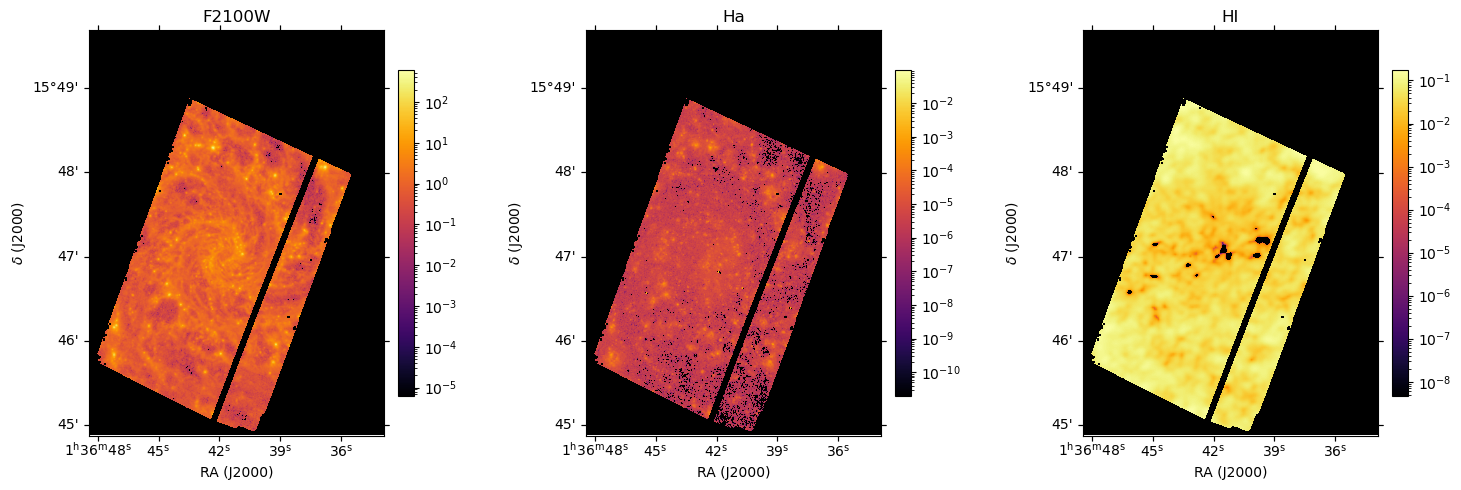

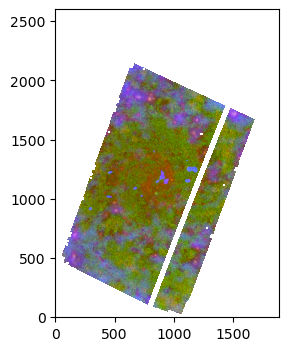

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=100, subplot_kw={'projection': reference_wcs})

images = [image_F2100W_new, image_Ha_new, image_HI_new]
titles = ['F2100W', 'Ha', 'HI']

for ax, data, title in zip(axes, images, titles):
    cmap = plt.cm.inferno.copy()
    cmap.set_bad(color='black')
    '''
    if (title == 'F2100W'):
        vmin = 1e-2
    if (title == 'Ha'):
        vmin = 1e-2
    if (title == 'HI'):
        vmin = 2e-2
    '''
    
    im = ax.imshow(data, cmap=cmap, origin='lower', norm=LogNorm())
    ax.set_title(title)
    ax.set_xlabel('RA (J2000)')
    ax.set_ylabel(r'$\delta$ (J2000)')

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


def log_normalize(image, vmin, vmax):
    norm = LogNorm(vmin=vmin, vmax=vmax)
    normed = norm(image)
    return np.clip(normed, 0, 1)
    
vmin_F2100W, vmax_F2100W = 1e-2, np.nanmax(image_F2100W_new)
vmin_Ha, vmax_Ha = 1e-6, np.nanmax(image_Ha_new)
vmin_HI, vmax_HI = 3e-2, np.nanmax(image_HI_new)

R = log_normalize(image_F2100W_new, vmin_F2100W, vmax_F2100W)
G = log_normalize(image_Ha_new, vmin_Ha, vmax_Ha)
B = log_normalize(image_HI_new, vmin_HI, vmax_HI)

rgb_image = np.dstack((R, G, B))

plt.figure(figsize=(4,4))
plt.imshow(rgb_image, origin='lower')
ax.set_xlabel('RA (J2000)')
ax.set_ylabel(r'$\delta$ (J2000)')
ax.set_title(r'RGB: HI, F2100W, H$\alpha$')
plt.axis('on')
plt.show()

# Leroy 2023

Leroy + (2006) "The Star Formation Efficiency in Nearby Galaxies: Measuring Where Gas Forms Stars Effectively".

In [6]:

reference_pixscale_arcsec = np.abs(reference_wcs.wcs.cdelt[0]) * 3600
resam_pixscale_arcsec = 1.7
scale_factor = reference_pixscale_arcsec / resam_pixscale_arcsec
print('From a pixelscale of ' + str(reference_pixscale_arcsec) + ' to ' + str(resam_pixscale_arcsec))
print('Reample factor: ' + str(scale_factor))

reference_shape = (image_F2100W_new.shape[0], image_F2100W_new.shape[1])
resam_shape = (int(reference_shape[0] * scale_factor), int(reference_shape[1] * scale_factor))
print('From ' + str(reference_shape) + ' to ' + str(resam_shape))
print()

resam_wcs = reference_wcs.deepcopy()
resam_wcs.wcs.cdelt = np.array([-resam_pixscale_arcsec/3600 if resam_wcs.wcs.cdelt[0] < 0 else resam_pixscale_arcsec/3600, resam_pixscale_arcsec/3600 if resam_wcs.wcs.cdelt[1] > 0 else -resam_pixscale_arcsec/3600])

image_F2100W_resam, footprint = reproject_interp((image_F2100W_new, reference_wcs), resam_wcs)
image_HI_resam, footprint = reproject_interp((image_HI_new, reference_wcs), resam_wcs)
image_Ha_resam, footprint = reproject_interp((image_Ha_new, reference_wcs), resam_wcs)

print('Means after resampling')
print('IR: ' + str(np.nanmean(image_F2100W_resam)))
print('HI: ' + str(np.nanmean(image_HI_resam)))
print('Ha: ' + str(np.nanmean(image_Ha_resam)))

From a pixelscale of 0.11092585445710201 to 1.7
Reample factor: 0.06525050262182472
From (2600, 1891) to (169, 123)

Means after resampling
IR: 1.4249202277988549
HI: 0.04895772123876125
Ha: 7.420507996848855e-06


7.420507996848855e-06


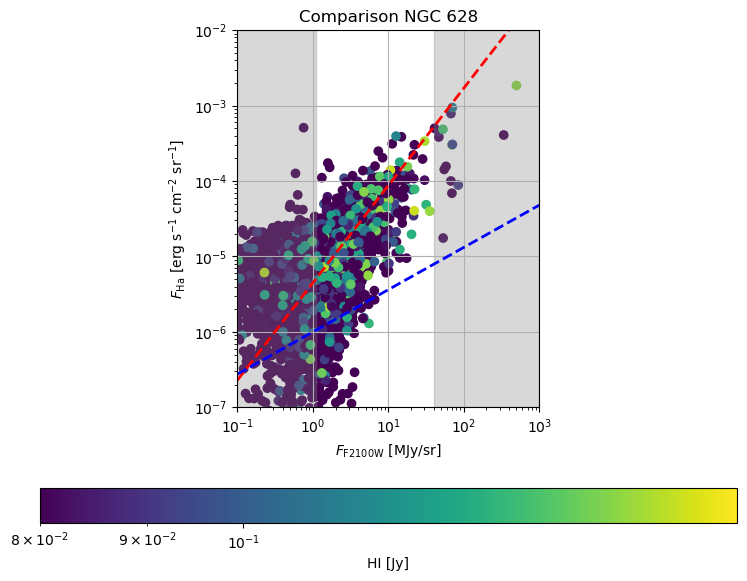

In [8]:
print(np.nanmean(np.nanmean(image_Ha_resam)))

fig, ax = plt.subplots(figsize=(9, 7))

cf = ax.scatter(image_F2100W_resam, image_Ha_resam, c=image_HI_resam, cmap='viridis', norm=LogNorm(vmin=8e-2))

ax.set_xlabel(r'$F_{\mathrm{F2100W}}$ [MJy/sr]')
ax.set_ylabel(r'$F_{\mathrm{Ha}}$ [erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(r'Comparison NGC 628')
ax.grid(True)

ax.axvspan(1e-1, 1.1e0, color='gray', alpha=0.3)
ax.axvspan(10**1.6, 1e3, color='gray', alpha=0.3)

ax.set_xlim(1e-1, 1e3)
ax.set_ylim(1e-7, 1e-2)

x_line = np.linspace(1e-1, 1e3, 100)
y_line = 1.29 * np.log10(x_line) - 5.35
y_line2= 0.56 * np.log10(x_line) - 6
ax.plot(x_line, 10**y_line, 'r--', lw=2)
ax.plot(x_line, 10**y_line2, 'b--', lw=2)

cbar = fig.colorbar(cf, ax=ax, orientation='horizontal', pad=0.15)
cbar.set_label(r'HI [Jy]')
ax.set_aspect('equal')
plt.show()

# Real PHANGS/THINGS emission ratios

# Finding the peaks in image_F2100W and image_Ha_new

Only in Ha: 12
Only in F2100W: 4
In both: 13


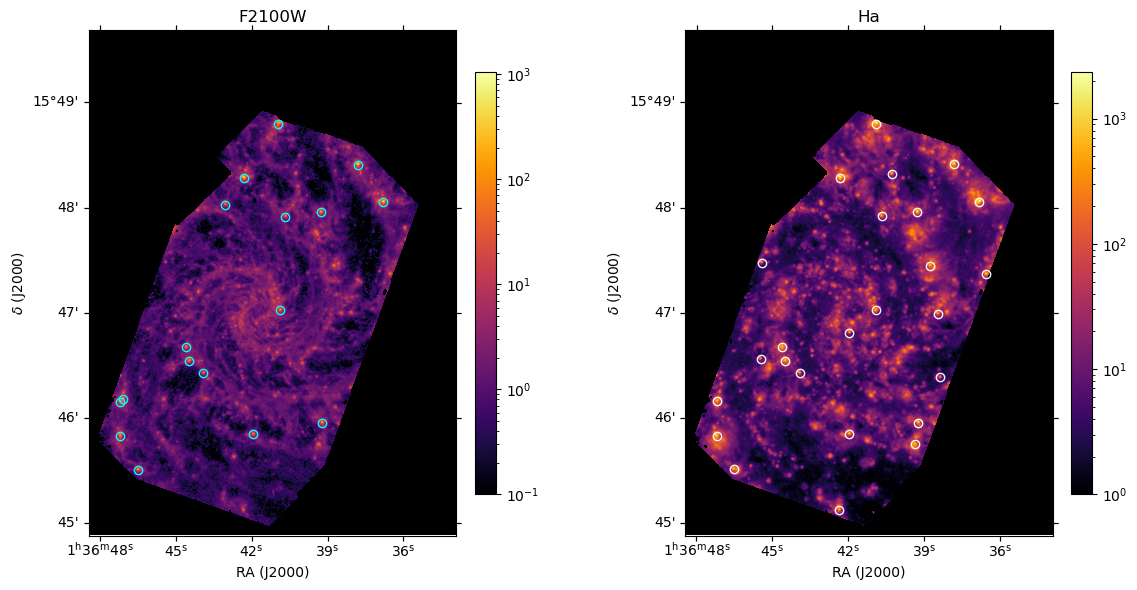

In [29]:
threshold_Ha = 5e2
threshold_F2100W = 1e2
theres = 5
peaks_coords_Ha = peak_local_max(image_Ha_new, min_distance=theres, threshold_abs=threshold_Ha)
peaks_coords_F2100W = peak_local_max(image_F2100W_new, min_distance=theres, threshold_abs=threshold_F2100W)

tree_F2100W = cKDTree(peaks_coords_F2100W)
distances, indexes = tree_F2100W.query(peaks_coords_Ha, distance_upper_bound=theres)

match_mask_Ha = distances < theres
match_mask_F2100W = np.full(len(peaks_coords_F2100W), False)
valid_indexes = indexes[match_mask_Ha]
match_mask_F2100W[valid_indexes] = True

only_Ha = peaks_coords_Ha[~match_mask_Ha]
only_F2100W = peaks_coords_F2100W[~match_mask_F2100W]
both = peaks_coords_Ha[match_mask_Ha]

print('Only in Ha: ' + str(len(only_Ha)))
print('Only in F2100W: ' + str(len(only_F2100W)))
print('In both: ' + str(len(both)))

fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': reference_wcs})
titles = ['F2100W', 'Ha']
images = [image_F2100W_new, image_Ha_new]
coords_list = [peaks_coords_F2100W, peaks_coords_Ha]

for ax, img, coords, title in zip(axes, images, coords_list, titles):
    cmap = plt.cm.inferno.copy()
    cmap.set_bad('black')

    if (title == 'F2100W'):
        vmin = 1e-1
        colorcircles='cyan'
    if (title == 'Ha'):
        vmin = 1e0
        colorcircles='aliceblue'
        
    norm = LogNorm(vmin=vmin, vmax=np.nanmax(img))
    im = ax.imshow(img, cmap=cmap, origin='lower', norm=norm)
    ax.plot(coords[:, 1], coords[:, 0], 'o', markerfacecolor='none', markeredgecolor=colorcircles, markersize=6)
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(title)
    ax.set_xlabel('RA (J2000)')
    ax.set_ylabel(r'$\delta$ (J2000)')

plt.tight_layout()
plt.show()